# Based on 
https://github.com/bnsreenu/python_for_microscopists/blob/master/251_satellite_image_to_maps_translation/pix2pix_model.py

https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/pix2pix/models.py

In [2]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.3 MB/s eta 0:00:0000:010:01


In [3]:
!pip install --upgrade ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 3.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 45.6 MB/s eta 0:00:0000:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
big

In [4]:
import os
import time
import datetime
import sys
import numpy as np
import nibabel as nib
import monai
import torch
from torchvision.utils import make_grid
from torchvision.utils import save_image
import torch.nn as nn
import matplotlib.pyplot as plt
from monai.data import DataLoader,pad_list_data_collate,Dataset
from monai.transforms import Compose,LoadImaged,EnsureChannelFirstd,Transposed,RandSpatialCropd,ToTensord

In [5]:
def load_images(directory_pelvis: str, device=None):
    """
    Load MRI and CT images, preprocess them, and return preprocessed pairs on the specified device.

    Args:
        directory_pelvis (str): Path to the dataset directory.
        device (torch.device): Device to which the tensors will be moved (e.g., 'cuda' or 'cpu').

    Returns:
        list: A list of dictionaries containing preprocessed 'mr' and 'ct' images.
    """
    
    # Default to CPU if no device is specified
    if device is None:
        device = torch.device("cpu")

    dataset = []
    processed_images = []
    
    for folder_patient in os.listdir(directory_pelvis):
        patient_path = os.path.join(directory_pelvis, folder_patient)
        #print(patient_path)

        # Load MRI and CT images for each patient
        mri_processed_path = os.path.join(patient_path, "mr_processed.nii") 
        ct_processed_path = os.path.join(patient_path, "ct_processed.nii")

        if os.path.exists(mri_processed_path) and os.path.exists(ct_processed_path):
            dataset.append({"mr": mri_processed_path,"ct": ct_processed_path})

    transforms = Compose([
        LoadImaged(keys=["mr", "ct"]),
        EnsureChannelFirstd(keys=["mr", "ct"]),
        # Permute dimensions of tensors to match the desired order
        # [C, D, W, H]->[C, H, W, D]
        Transposed(keys=["mr", "ct"], indices=(0, 3, 2, 1)),
        RandSpatialCropd(keys=["mr", "ct"], roi_size=(256, 256, 16), random_size=False), # Random Crop
        ToTensord(keys=["mr", "ct"])
    ])  

    monai_dataset = Dataset(data=dataset, transform=transforms)
    train_dataset, val_dataset = torch.utils.data.random_split(monai_dataset, [0.8, 0.2])
    
    # The paper states that batch_size=1 provides better results
    train_dl = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0, collate_fn=pad_list_data_collate) # to handle tensors of different sizes
    val_dl = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=0, collate_fn=pad_list_data_collate)
    
    return train_dataset,val_dataset, train_dl, val_dl

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset,val_dataset, train_dl, val_dl = load_images("/kaggle/input/synthrad-processed-dataset-this",device=device)


In [6]:
for i, image in enumerate(train_dataset):
    #print(f"Processed shape: {image['mr'][0]-image['mr'][1]}") # image['mr'][0][0][2] - FIRST BATCH, FIRST CHANNEL, THIRD SLICE
    print(f"Processed shape: {image['mr'].shape}")
    print(f"Processed shape: {image['ct'].shape}")

for real_images in train_dl:
    #print( {real_images['mr'][0]-real_images['mr'][1]}) # batches iguais =0
    print("Train images: ",real_images["mr"].shape) 

for real_images in val_dl:
    print("Val images: ",real_images["mr"].shape)


Processed shape: torch.Size([1, 256, 256, 16])
Processed shape: torch.Size([1, 256, 256, 16])
Processed shape: torch.Size([1, 256, 256, 16])
Processed shape: torch.Size([1, 256, 256, 16])
Processed shape: torch.Size([1, 256, 256, 16])
Processed shape: torch.Size([1, 256, 256, 16])
Processed shape: torch.Size([1, 256, 256, 16])
Processed shape: torch.Size([1, 256, 256, 16])
Processed shape: torch.Size([1, 256, 256, 16])
Processed shape: torch.Size([1, 256, 256, 16])
Train images:  torch.Size([1, 1, 256, 256, 16])
Train images:  torch.Size([1, 1, 256, 256, 16])
Train images:  torch.Size([1, 1, 256, 256, 16])
Train images:  torch.Size([1, 1, 256, 256, 16])
Train images:  torch.Size([1, 1, 256, 256, 16])
Val images:  torch.Size([1, 1, 256, 256, 16])


Patient Slices for training (Figure 1)


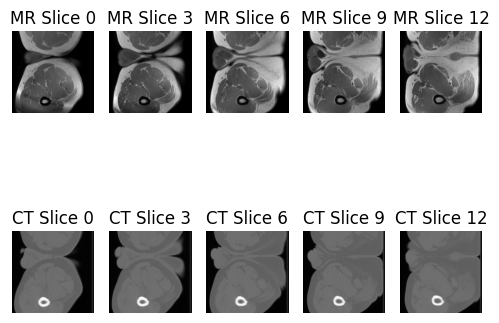

Patient Slices for training (Figure 2)


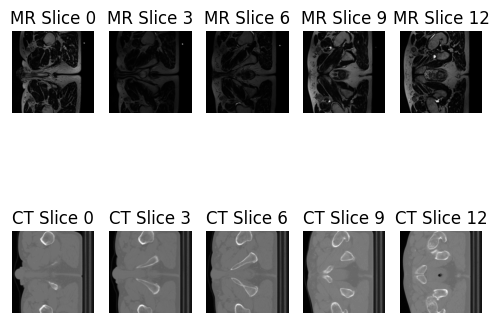

Patient Slices for training (Figure 3)


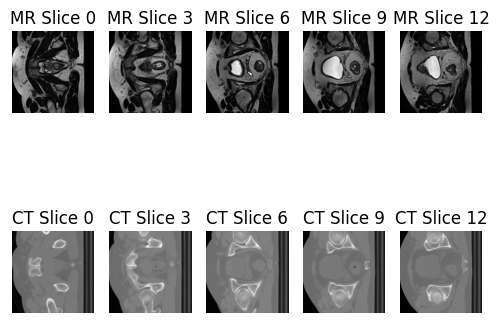

Patient Slices for training (Figure 4)


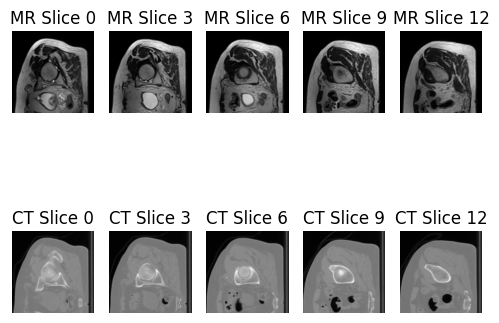

Patient Slices for training (Figure 5)


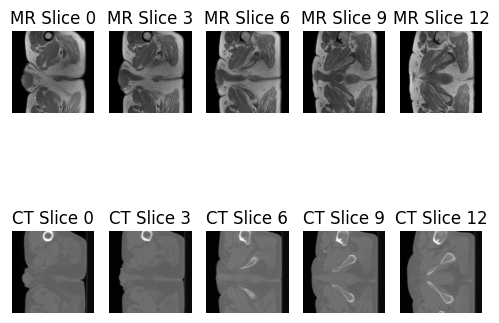

Patient Slices for validation (Figure 1)


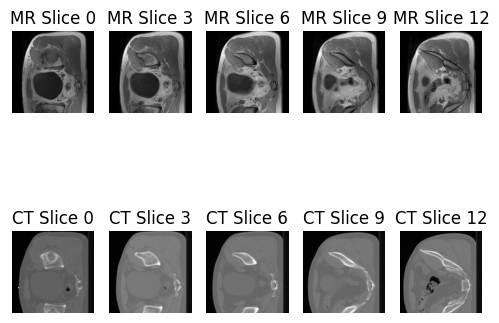

In [7]:
def visualize_image(image, num_slices=5, title="Slices", number_of_img=None):
    """
    Visualize multiple 2D slices from a 3D medical image for MR and CT, 
    with a title that includes the patient ID.
    
    Args:
        image (dict): A dictionary containing the 'mr' and 'ct' keys with the respective images.
        num_slices (int): The number of slices to visualize.
        title (str): Title of the plot.
        patient_id (int, optional): The ID of the patient to display in the title.
    """
    mr_image = image['mr'].cpu().numpy() 
    ct_image = image['ct'].cpu().numpy() 
    
    fig, axes = plt.subplots(2, num_slices, figsize=(5, 5)) 

    print(f"{title} (Figure {number_of_img+1})")

    for i in range(num_slices):
        slice_idx = i * (mr_image.shape[3] // num_slices)  
        axes[0, i].imshow(mr_image[0, :, :, slice_idx], cmap='gray') 
        axes[0, i].set_title(f'MR Slice {slice_idx}')
        axes[0, i].axis('off') 
    
    for i in range(num_slices):
        slice_idx = i * (ct_image.shape[3] // num_slices) 
        axes[1, i].imshow(ct_image[0, :, :, slice_idx], cmap='gray')  
        axes[1, i].set_title(f'CT Slice {slice_idx}')
        axes[1, i].axis('off') 
    
    plt.tight_layout() 
    plt.show()  

for i, image in enumerate(train_dataset):
    visualize_image(image, num_slices=5, title="Patient Slices for training", number_of_img=i)

for i, image in enumerate(val_dataset):
    visualize_image(image, num_slices=5, title="Patient Slices for validation", number_of_img=i)


# Defining generator, discriminator, gan and other helper functions.

Since pix2pix is a conditional GAN, it takes 2 inputs: image (MRI) and corresponding label.

For pix2pix the label will be another image (CT). 

# Discriminator Network

-> Define the standalone discriminator model (PatchGAN discriminator)

Given an input image, the Discriminator outputs the likelihood of the image being real. It is a binary classification - true or false (1 or 0) that is why it uses sigmoid activation. The discriminator is a binary classifier that is classifying images as real/fake.

-> From the paper C64-C128-C256-C512

After the last layer, conv to 1-dimensional output, followed by a Sigmoid function.  

In [23]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=1): # 1 channel
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, kernel_size=4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            # Concatenate channels of img_A with img_B = 2 channels
            *discriminator_block(in_channels * 2, 64, normalization=False), # C64
            *discriminator_block(64, 128), # C128
            *discriminator_block(128, 256), # C256
            *discriminator_block(256, 512), # C512
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, kernel_size=4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        # -> img_A = Image we want to convert to another image (MRI)
        # -> img_B = Image we want to generate after training, target (CT)
        img_input = torch.cat((img_A, img_B), dim=1)
        #print("Concatenated images shape:", img_input.shape)
        return self.model(img_input)

In [12]:
# In order to have a PatchGAN discriminator with patches of size 70x70 (according to the paper) in the original image,
# the input image size should be 256x256 (original image). Then, the output of the discriminator, it will be an image of size 16x16.

# 1. Input original image (256x256): has 70x70 patches that will be seen by the discriminator.
# 2. PatchGAN discriminator: it will classify a 16x16 output size as real or fake (this is calculated from the discriminator architecture)
# 3. Then, it will average the classification of all patches

discriminator = Discriminator(in_channels=1)

# Sanity Test - 1 slice of each image
img_A = torch.randn(1, 1, 256, 256)  # MRI
img_B = torch.randn(1, 1, 256, 256)  # CT

output = discriminator(img_A, img_B)

print("Input img_A shape:", img_A.shape)
print("Input img_B shape:", img_B.shape)
print("Output shape:", output.shape)

Concatenated images shape: torch.Size([1, 2, 256, 256])
Input img_A shape: torch.Size([1, 1, 256, 256])
Input img_B shape: torch.Size([1, 1, 256, 256])
Output shape: torch.Size([1, 1, 16, 16])


# Generator
The generator is a modified U-Net.

Each block in the encoder is: Convolution -> Batch normalization -> LeakyReLU. General model of the encoder: C64-C128-C256-C512-C512-C512-C512-C512

Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU. General model of the decorde: CD512-CD512-CD512-C512-C256-C128-C64

There are also the skip connections between the encoder and the decoder.

In [13]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# Encoder block

In [15]:
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, kernel_size=4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Decoder block

In [16]:
class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

# U-Net -> generator model

Colocaram dropout de 0.5 em algumas layers que não estava no artigo original da pixtopix.

In [18]:
# Sanity test
input_img = torch.randn(1, 1, 256, 256)  # (B, C, H, W)
model = GeneratorUNet(in_channels=1, out_channels=1)

output = model(input_img)

print(f"Input shape: {input_img.shape}")
print(f"Output shape: {output.shape}")


Input shape: torch.Size([1, 1, 256, 256])
Output shape: torch.Size([1, 1, 256, 256])


# Configuration dictionary

len(train_dl)=5 batches per epoch.

sample_interval = 5:
This means sample_images will be called every 5 batches.
Since it is 5 batches per epoch, it will be called once at the end of every epoch (batches_done = 5, 10, 15, ...).

In [64]:
config = {
    "epoch": 99,  # Epoch to start training from - CHANGE to the number of the last epoch in order to have continuous training
    "n_epochs": 200,  # Number of epochs of training - CHANGE
    "dataset_name": "SynthRAD",  # Name of the dataset
    "batch_size": 1,  # Size of the batches
    "lr": 0.0002,  # Learning rate for Adam optimizer
    "b1": 0.5,  # Adam: decay of first order momentum of gradient
    "b2": 0.999,  # Adam: decay of first order momentum of gradient
    "decay_epoch": 50,  # Epoch from which to start LR decay
    "n_cpu": 8,  # Number of CPU threads to use during batch generation
    "img_height": 256,  # Size of image height
    "img_width": 256,  # Size of image width
    "channels": 1,  # Number of image channels
    "sample_interval": 5,  # Interval between sampling of images from generators (de 5 em 5 batches)
    "checkpoint_interval": 5,  # Interval between model checkpoints (de 5 em 5 batches)
}

print("Configuration:", config)

Configuration: {'epoch': 99, 'n_epochs': 200, 'dataset_name': 'SynthRAD', 'batch_size': 1, 'lr': 0.0002, 'b1': 0.5, 'b2': 0.999, 'decay_epoch': 50, 'n_cpu': 8, 'img_height': 256, 'img_width': 256, 'channels': 1, 'sample_interval': 5, 'checkpoint_interval': 5}


In [65]:
os.makedirs(f"images/{config['dataset_name']}", exist_ok=True)
os.makedirs(f"saved_models/{config['dataset_name']}", exist_ok=True)

cuda = True if torch.cuda.is_available() else False

# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

# Calculate output of image discriminator (PatchGAN)
patch = (1, config['img_height'] // 2 ** 4, config['img_width'] // 2 ** 4)
#print(patch) # (1, 16, 16)

# Initialize generator and discriminator
generator = GeneratorUNet()
discriminator = Discriminator()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    criterion_GAN.cuda()
    criterion_pixelwise.cuda()

# This allows the training process to continue from a previous state, without starting over from scratch everytime it runs until total number of epochs
if config['epoch'] != 0:
    # Load pretrained models
    print("Loading pretrained models at epoch:",config['epoch'])
    generator.load_state_dict(torch.load(f"saved_models/{config['dataset_name']}/generator_{config['epoch']}.pth"))
    discriminator.load_state_dict(torch.load(f"saved_models/{config['dataset_name']}/discriminator_{config['epoch']}.pth"))
else:
    # Initialize weights
    generator.apply(weights_init_normal)
    discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=config['lr'], betas=(config['b1'], config['b2']))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=config['lr'], betas=(config['b1'], config['b2']))

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

def sample_images(batches_done):
    """Saves a generated sample from the validation set"""
    imgs = next(iter(val_dl))
    real_A = imgs["mr"].to(device)  # Shape: [B, C, H, W, D]
    real_B = imgs["ct"].to(device)  # Shape: [B, C, H, W, D]

    # Select a slice (slice number 1) - Shape: [B, C, H, W]
    real_A = real_A[:,:,:,:,0]
    real_B = real_B[:,:,:,:,0]
    
    fake_B = generator(real_A)
    img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2)
    save_image(img_sample, f"images/{config['dataset_name']}/{batches_done}.png", nrow=5, normalize=True)

Loading pretrained models at epoch: 99


/tmp/ipykernel_30/1033980178.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(f"saved_models/{config['dataset_name']}/generator_{con

# Generator training

This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

We generate a batch of images using the generator, pass the into the discriminator.

We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator. 

We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

# Discriminator training
Binary classifitcation model

Here are the steps involved in training the discriminator.

We expect the discriminator to output 1 if the image was picked from the real dataset, and 0 if it was generated using the generator network. 

We first pass a batch of real images, and compute the loss, setting the target labels to 1. 

Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0. 

Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

In [67]:
# ----------
#  Training
# ----------

# Initialize tracking variables
best_generator_loss = float('inf')
best_epoch = -1
best_batch = -1

all_loss_D = []
all_loss_G = []


prev_time = time.time()

for epoch in range(config['epoch'], config['n_epochs']):
    for i, batch in enumerate(train_dl):

        # Model inputs
        real_A = batch["mr"].to(device)  # Shape: [B, C, H, W, D]
        real_B = batch["ct"].to(device)  # Shape: [B, C, H, W, D]

        # Select a slice (slice number 1) - Shape: [B, C, H, W]
        real_A = real_A[:,:,:,:,0]
        real_B = real_B[:,:,:,:,0]
        #print(type(real_A))
        
        # Adversarial ground truths
        valid = torch.ones((real_A.size(0), *patch), device=device, requires_grad=False) # label of real images = 1's
        fake = torch.zeros((real_A.size(0), *patch), device=device, requires_grad=False) # label of fake images = 0's

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # GAN loss
        fake_B = generator(real_A)
        pred_fake = discriminator(fake_B, real_A) # FAKE INPUT
        loss_GAN = criterion_GAN(pred_fake, valid) # img,label
        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(fake_B, real_B)

        # Total loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(real_B, real_A) # REAL INPUT
        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_B.detach(), real_A)
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------

        # Determine approximate time left
        batches_done = epoch * len(train_dl) + i
        batches_left = config['n_epochs'] * len(train_dl) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        # Print log
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, pixel: %f, adv: %f] ETA: %s"
            % (
                epoch,
                config['n_epochs'],
                i,
                len(train_dl),
                loss_D.item(),
                loss_G.item(),
                loss_pixel.item(),
                loss_GAN.item(),
                time_left,
            )
        )

        # Track best generator performance (can be based on generator loss, for example)
        if loss_G.item() < best_generator_loss:
            best_generator_loss = loss_G.item()
            best_epoch = epoch
            best_batch = i
            sample_images(best_batch)

        # If at sample interval save image
        #if batches_done % config['sample_interval'] == 0: 
            #sample_images(batches_done)

    if config['checkpoint_interval'] != -1 and epoch % config['checkpoint_interval'] == 0:
        # Save model checkpoints:
        # 1. Model parameters (weights and bias)
        # 2. Batch norm
        torch.save(generator.state_dict(), f"saved_models/{config['dataset_name']}/generator_{epoch}.pth")
        torch.save(discriminator.state_dict(), f"saved_models/{config['dataset_name']}/discriminator_{epoch}.pth")

    all_loss_D.append(loss_D)
    all_loss_G.append(loss_G)

print(f"Best Generator Loss: {best_generator_loss}")
print(f"Best Epoch: {best_epoch}, Best Batch: {best_batch}")

[Epoch 199/200] [Batch 4/5] [D loss: 0.222088] [G loss: 6.692763, pixel: 0.062177, adv: 0.475034] ETA: 0:00:00.166035Best Generator Loss: 4.213753700256348
Best Epoch: 174, Best Batch: 3


In [ ]:
%cd /kaggle/working
import shutil
shutil.make_archive("generated_data_cGAN", 'zip', "generated")

In [ ]:
from IPython.display import FileLink
FileLink(r'generated_data_cGAN.zip')
